# Econ 251 Writing Asssignment Supplement

## Anup Bottu

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import scipy.stats as stats

import warnings
warnings.filterwarnings("ignore")

In [2]:
# import factors
xls = pd.ExcelFile("Quality Minus Junk Factors Monthly.xlsx")
mkt_series = 100*pd.read_excel(xls, "MKT", skiprows = 18, index_col = 0).loc[:, "USA"]
smb_series = 100*pd.read_excel(xls, "SMB", skiprows = 18, index_col = 0).loc[:, "USA"]
rf_series = 100*pd.read_excel(xls, "RF", skiprows = 18, index_col = 0).loc[:, "Risk Free Rate"]
hml_series = 100*pd.read_excel(xls, "HML FF", skiprows = 18, index_col = 0).loc[:, "USA"]
umd_series = 100*pd.read_excel(xls, "UMD", skiprows = 18, index_col = 0).loc[:, "USA"]

factors_df = pd.DataFrame({"MKT-RF": mkt_series-rf_series, "SMB": smb_series, "HML": hml_series, "UMD": umd_series})

# import quality portfolios
xls = pd.ExcelFile("Quality Minus Junk 10 QualitySorted Portfolios Monthly.xlsx")
quality_portfolios_df = 100*pd.read_excel(xls, "10 Portfolios Formed on Quality", skiprows = 18, index_col = 0).iloc[:, :10] # Sheet 1

In [3]:
# function that performs time series regression

def perform_time_series_regression(factor_names, index):

    factors = factors_df.loc[:, factor_names]
    error_terms_df = pd.DataFrame(columns = quality_portfolios_df.columns)
    factor_loadings_df = pd.DataFrame(index = quality_portfolios_df.columns, \
        columns = ["Alpha"] + factor_names)

    # Time Series Regression
    for portfolio in quality_portfolios_df.columns:
        Y = quality_portfolios_df.loc[index, portfolio] - rf_series.loc[index]
        X = sm.add_constant(factors.loc[index, :])
        regression_result = sm.OLS(Y, X, missing = "drop").fit()
        error_terms_df[portfolio] = regression_result.resid
        factor_loadings_df.loc[portfolio, :] = list(regression_result.params)

    # Calculate GRS F-Statistic and p-value
    omega = mkt_series.var()
    a = factor_loadings_df.loc[:, "Alpha"].to_numpy()
    mu = mkt_series.mean()
    sigma = error_terms_df.cov().to_numpy()

    W = a.dot(np.linalg.inv(sigma)).dot(a) / (1 + mu * omega**(-1) * mu)

    T = len(index)
    N = len(quality_portfolios_df.T)
    L = len(factors.T)
    W_normalized = W * (T/N) * (T-N-L) / (T-L-1)

    print("Alphas and Factor Loadings:")
    display(factor_loadings_df)
    print(f'F-Statistic = {W_normalized}')
    print(f'p-value = {1 - stats.f.cdf((W_normalized), N, T-N-L)}') 

    return factor_loadings_df.iloc[:, 0]

In [4]:
# storing alphas for final figure 

alphas_df = pd.DataFrame(index = quality_portfolios_df.columns, \
    columns = ["Paper CAPM Alpha", "Paper 4 Factor Alpha", \
        "Recent CAPM Alpha", "Recent 4 Factor Alpha"])

## <u> Part I: Recreating Paper Results (1957-2016) </u>

In [5]:
paper_index_end = quality_portfolios_df.index.get_loc("2016-12-31")
paper_index = quality_portfolios_df.iloc[: paper_index_end, :].index
index = paper_index.intersection(factors_df.index)

### a) Testing Quality Portfolios Against the CAPM

In [6]:
factor_names = ["MKT-RF"]
alphas_df.loc[:, "Paper CAPM Alpha"] = perform_time_series_regression(factor_names, index)

Alphas and Factor Loadings:


,Alpha,MKT-RF
P1 (low quality),-0.410589,1.341999
P2,-0.149642,1.211163
P3,-0.099504,1.076454
P4,-0.037613,1.047318
P5,-0.053721,0.967851
P6,0.053595,0.999716
P7,0.08033,0.990277
P8,0.000342,0.979799
P9,0.153521,0.952708
P10 (high quality),0.146755,0.918196


F-Statistic = 3.3199896602686385
p-value = 0.00031514321596504136


### b) Testing Quality Portfolios Against the Carhart Four Factor Model

In [7]:
factor_names = ["MKT-RF", "SMB", "HML", "UMD"]
alphas_df.loc[:, "Paper 4 Factor Alpha"] = perform_time_series_regression(factor_names, index)

Alphas and Factor Loadings:


,Alpha,MKT-RF,SMB,HML,UMD
P1 (low quality),-0.443717,1.238949,0.589928,0.1026,-0.104855
P2,-0.23276,1.192931,0.295913,0.250473,-0.050216
P3,-0.141279,1.070805,0.181667,0.224971,-0.074979
P4,-0.08511,1.070812,0.045133,0.227299,-0.044032
P5,-0.093681,1.014299,-0.07024,0.236371,-0.037878
P6,0.005517,1.028321,-0.024476,0.138381,0.008492
P7,0.019022,1.014085,0.006753,0.128555,0.025329
P8,-0.024154,0.996193,-0.025295,0.062845,0.009993
P9,0.19693,0.949774,-0.067705,-0.080217,-0.011575
P10 (high quality),0.245146,0.888102,-0.118373,-0.339853,0.037571


F-Statistic = 5.834649246744047
p-value = 1.7598182910916194e-08


## <u> Part II: Extending Paper Results (2011-2021) </u>

In [8]:
paper_index_start = quality_portfolios_df.index.get_loc("2011-09-30")
paper_index = quality_portfolios_df.iloc[paper_index_start: , :].index
index = paper_index.intersection(factors_df.index)

### a) Testing Quality Portfolios Against the CAPM

In [9]:
factor_names = ["MKT-RF"]
alphas_df.loc[:, "Recent CAPM Alpha"] = perform_time_series_regression(factor_names, index)

Alphas and Factor Loadings:


,Alpha,MKT-RF
P1 (low quality),-0.781595,1.445675
P2,-0.388346,1.302777
P3,-0.501506,1.163944
P4,-0.224508,1.082327
P5,-0.154477,0.997975
P6,-0.191525,1.079568
P7,-0.222719,1.012887
P8,0.046912,1.022303
P9,0.315203,0.922847
P10 (high quality),0.259821,0.881338


F-Statistic = 2.1194875360432115
p-value = 0.028591370915635128


### b) Testing Quality Portfolios Against the Carhart Four Factor Model

In [10]:
factor_names = ["MKT-RF", "SMB", "HML", "UMD"]
alphas_df.loc[:, "Recent 4 Factor Alpha"] = perform_time_series_regression(factor_names, index)

Alphas and Factor Loadings:


,Alpha,MKT-RF,SMB,HML,UMD
P1 (low quality),-0.429259,1.133422,1.134669,-0.053456,-0.084346
P2,-0.162739,1.122361,0.623549,0.029621,-0.051337
P3,-0.370756,1.068161,0.301353,0.038186,-0.038503
P4,-0.110232,1.041178,0.211774,0.269331,0.09755
P5,-0.042202,0.977792,-0.021164,0.26231,0.009845
P6,-0.02524,1.012231,0.111166,0.235261,-0.030432
P7,-0.145269,0.988021,0.031569,0.138689,-0.003089
P8,0.093963,1.002055,-0.029919,0.024788,-0.057844
P9,0.198181,0.988289,-0.1262,-0.080073,0.05816
P10 (high quality),0.128384,0.946998,-0.234363,-0.190567,-0.032901


F-Statistic = 1.843218556723222
p-value = 0.06157629066573567


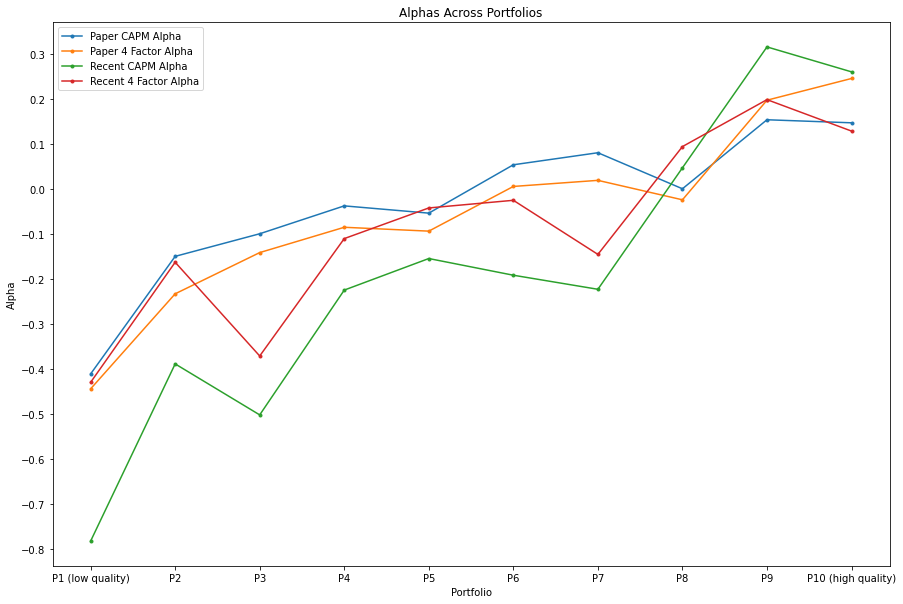

In [11]:
ax = alphas_df.plot(style='.-', figsize=(15,10), title = "Alphas Across Portfolios", ylabel = "Alpha", xlabel = "Portfolio");
ax.locator_params("y", nbins = 15);
ax.set_xticks(range(0,10));
ax.set_xticklabels(quality_portfolios_df.columns);